In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve

In [3]:
SBA_fix = pd.read_csv('SBA_fix.csv')
SBA_fix = SBA_fix.drop(columns = ['Unnamed: 0'], axis =1)

In [4]:
SBA_fix.head()

,Term,NewExist,IsRetainedJob,RevLineCr,LowDoc,DisbursementGross,MIS_Status,SBA_Appv,Recession,SectorRate,State_rate
0,84,1.0,0,0.0,1.0,60000.0,0.0,48000.0,0,0.23,20
1,60,1.0,0,0.0,1.0,40000.0,0.0,32000.0,0,0.22,20
2,180,0.0,0,0.0,0.0,287000.0,0.0,215250.0,0,0.10,20
3,120,0.0,0,0.0,0.0,517000.0,0.0,387750.0,0,0.14,16
4,84,1.0,0,0.0,1.0,45000.0,0.0,36000.0,0,0.20,33


In [5]:
# Train Test Split
X = SBA_fix.drop(['MIS_Status'],axis=1)
y = SBA_fix['MIS_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2020, stratify=y)

In [6]:
X = SBA_fix.drop(['MIS_Status'],axis=1)
y = SBA_fix['MIS_Status']

scale = StandardScaler()
X_scaled = scale.fit_transform(X)

# MIS_Status/ kolom target imbalance (terlihat pada saat EDA)
# jadi akan dilakukan SMOTE dan undersampling https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
over = SMOTE(sampling_strategy='minority') 
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)


X_train, y_train = pipeline.fit_resample(X_train, y_train)

## Logistic Regression

In [7]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_train_ypred = logreg.predict(X_train)
y_train_prob = logreg.predict_proba(X_train)[:,-1]

In [8]:
y_test_ypred = logreg.predict(X_test)
y_test_prob = logreg.predict_proba(X_test)[:,-1]
y_probas = logreg.predict_proba(X_test)

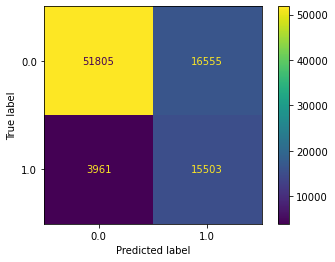

In [9]:
plot_confusion_matrix(logreg, X_test, y_test)

In [10]:
print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))

Classification Report: 
               precision    recall  f1-score   support

         0.0      0.929     0.758     0.835     68360
         1.0      0.484     0.796     0.602     19464

    accuracy                          0.766     87824
   macro avg      0.706     0.777     0.718     87824
weighted avg      0.830     0.766     0.783     87824



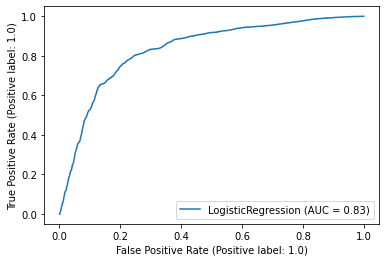

In [11]:
plot_roc_curve(logreg, X_test, y_test)

### Hyperparameter Tuning

In [12]:
param_grid_logreg = {
    'max_iter': [100, 200, 300],
}
gridsearch_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, scoring='roc_auc', cv=5, n_jobs=-1)
gridsearch_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [100, 200, 300]}, scoring='roc_auc')

In [13]:
gridsearch_logreg.best_params_

{'max_iter': 100}

In [15]:
logreg_grid = gridsearch_logreg.best_estimator_

In [16]:
logreg_grid_pred = logreg_grid.predict(X_test)
logreg_grid_proba = logreg_grid.predict_proba(X_test)

In [17]:
print('Classification Report: \n', classification_report(y_test, logreg_grid_pred, digits=3))

Classification Report: 
               precision    recall  f1-score   support

         0.0      0.929     0.758     0.835     68360
         1.0      0.484     0.796     0.602     19464

    accuracy                          0.766     87824
   macro avg      0.706     0.777     0.718     87824
weighted avg      0.830     0.766     0.783     87824



## XGBoost

In [18]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_train_ypred = xgb.predict(X_train)
y_train_prob = xgb.predict_proba(X_train)[:,-1]

[07:58:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [19]:
y_test_ypred = xgb.predict(X_test)
y_test_prob = xgb.predict_proba(X_test)[:,-1]
y_probas = xgb.predict_proba(X_test)

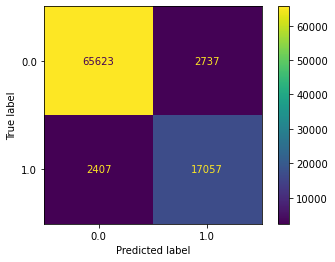

In [20]:
plot_confusion_matrix(xgb, X_test, y_test)

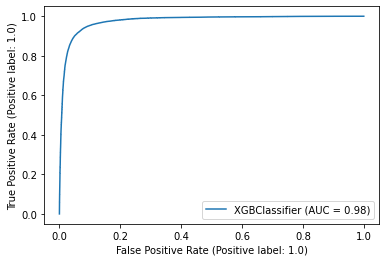

In [21]:
plot_roc_curve(xgb, X_test, y_test)

### Hyperparameter Tuning

In [24]:
param_grid_xgb = {
    'max_iter': [100, 200, 300],
}
gridsearch_xgb = GridSearchCV(estimator= xgb, param_grid=param_grid_xgb, scoring='roc_auc', cv=5, n_jobs=-1)
gridsearch_xgb.fit(X_train, y_train)

[08:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { max_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
         

In [25]:
gridsearch_xgb.best_params_

{'max_iter': 100}

In [26]:
xgb_grid = gridsearch_xgb.best_estimator_

In [27]:
xgb_grid_pred = xgb_grid.predict(X_test)
xgb_grid_proba = xgb_grid.predict_proba(X_test)

In [28]:
print('Classification Report: \n', classification_report(y_test, xgb_grid_pred, digits=3))

Classification Report: 
               precision    recall  f1-score   support

         0.0      0.965     0.960     0.962     68360
         1.0      0.862     0.876     0.869     19464

    accuracy                          0.941     87824
   macro avg      0.913     0.918     0.916     87824
weighted avg      0.942     0.941     0.942     87824



In [29]:
import joblib

In [35]:
joblib.dump(xgb_grid, 'xgb_grid')

['xgb_grid']

In [36]:
xgb_grid = joblib.load('xgb_grid')

In [37]:
xgb_grid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              max_iter=100, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [38]:
X_train.columns

Index(['Term', 'NewExist', 'IsRetainedJob', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'SBA_Appv', 'Recession', 'SectorRate',
       'State_rate'],
      dtype='object')

In [39]:
rose = [[1, 1, 17, 1, 1, 1, 1, 90, 1, 20]]
xgb_grid.predict(pd.DataFrame(rose, columns=X_train.columns))

array([1.])